In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report

drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [70]:
EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.04
MOMENTUM = 0.30

In [3]:
df = pd.read_csv('/gdrive/My Drive/coffe_sow/coffe_sow.csv', index_col=0)
df

,temperature,humidity,altitude,rain,sunshine,sow
0,20.56,0.5616,1792.51,157.98,5.00,1
1,19.89,0.4404,1491.87,138.53,5.18,0
2,19.13,0.6483,1442.02,135.11,4.93,1
3,18.18,0.6214,1508.78,158.78,5.08,0
4,23.06,0.6410,1595.61,161.61,4.88,0
...,...,...,...,...,...,...
9995,20.37,0.5752,1485.12,155.21,4.98,1
9996,20.29,0.5973,1397.37,143.33,5.06,1
9997,19.28,0.7241,1591.44,163.55,5.04,1
9998,22.12,0.5620,1302.65,133.17,5.03,0


In [4]:
df.describe()

,temperature,humidity,altitude,rain,sunshine,sow
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,20.031190,0.600133,1501.343551,150.148335,5.002200,0.392700
std,2.511048,0.079884,98.758814,10.009960,0.100253,0.488375
min,10.650000,0.304500,1144.500000,113.890000,4.620000,0.000000
25%,18.320000,0.547100,1436.455000,143.420000,4.940000,0.000000
50%,20.000000,0.601800,1501.770000,150.110000,5.000000,0.000000
75%,21.720000,0.652625,1567.337500,156.852500,5.070000,1.000000
max,29.620000,0.905900,1867.940000,189.960000,5.390000,1.000000


Target value
sow
0    6073
1    3927
Name: sow, dtype: int64


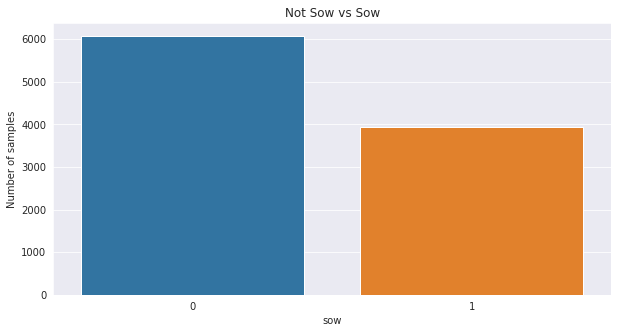

In [80]:
print('Target value')
print(df.groupby(['sow']).sow.count())

sns.set_style('darkgrid')
plt.figure(figsize = (10,5))
sns.countplot(x=df['sow'])
plt.title('Not Sow vs Sow')
plt.ylabel('Number of samples')
plt.show()

In [7]:
X = df.iloc[:,:-1].to_numpy()
y = df.iloc[:,-1].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=32)
dev_split_index = int(9 * len(X_train) / 10)
X_dev = X_train[dev_split_index:]
y_dev = y_train[dev_split_index:]
X_train = X_train[:dev_split_index]
y_train = y_train[:dev_split_index]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_dev = scaler.fit_transform(X_dev)
X_test = scaler.fit_transform(X_test)

In [8]:
def accuracy(y_pred, y_test):
    y = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [9]:
class TrainData(Dataset):
    
  def __init__(self, X_data, y_data):
    self.X_data = X_data
    self.y_data = y_data
        
  def __getitem__(self, index):
    return self.X_data[index], self.y_data[index]
        
  def __len__ (self):
    return len(self.X_data)

class TestData(Dataset):

  def __init__(self, X_data):
    self.X_data = X_data
        
  def __getitem__(self, index):
    return self.X_data[index]
        
  def __len__ (self):
    return len(self.X_data)

    
train_data = TrainData(torch.FloatTensor(X_train),torch.FloatTensor(y_train))
dev_data = TrainData(torch.FloatTensor(X_dev),torch.FloatTensor(y_dev))
test_data = TrainData(torch.FloatTensor(X_test), torch.FloatTensor(y_test))
test_report_data = TestData(torch.FloatTensor(X_test))

train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(dataset=dev_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)
test_report_loader = DataLoader(dataset=test_report_data, batch_size=1)

In [61]:
class Classificator(nn.Module):
    
  def __init__(self):
    super(Classificator, self).__init__()
        
    self.layer1 = nn.Linear(5, 10)
    self.layer2 = nn.Linear(10, 20)
    self.layer3 = nn.Linear(20, 15)
    self.output = nn.Linear(15, 1)
    self.leaky_relu = nn.LeakyReLU()
    self.dropout = nn.Dropout(p=0.5)
        
  def forward(self, X):
    x = self.leaky_relu(self.layer1(X))
    x = self.dropout(x)
    x = self.leaky_relu(self.layer2(x))
    x = self.dropout(x)
    x = self.leaky_relu(self.layer3(x))
    x = self.dropout(x)
    x = self.output(x)      
    return x

In [71]:
model = Classificator()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

In [81]:
def run_epoch(loader, model, optimizer, criterion):
  losses = []
  accuracies = []

  is_training = model.training

  for X_batch, y_batch in tqdm(loader):
    y_pred = model(X_batch)
    loss = criterion(y_pred, y_batch.unsqueeze(1))
    acc = accuracy(y_pred, y_batch.unsqueeze(1))
    losses.append(loss.item())
    accuracies.append(acc.item())
    
    if is_training:
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  avg_loss = np.sum(losses)/len(loader)
  avg_accuracy = np.sum(accuracies)/len(loader)
  return avg_loss, avg_accuracy

In [82]:
for epoch in range(1, EPOCHS+1):
  print(f"-------------\nEpoch {epoch}:\n")

  loss, acc = run_epoch(train_loader, model.train(), optimizer, criterion)
  print(f"\nTrain loss: {loss:.5f} | Train accuracy: {acc:.5f}")

  val_loss, val_acc = run_epoch(dev_loader, model.eval(), optimizer, criterion)
  print(f"Val loss:   {val_loss:.5f} | Val accuracy:   {val_acc:.5f}")

 41%|████▏     | 58/140 [00:00<00:00, 574.40it/s]

-------------
Epoch 1:



 42%|████▏     | 59/140 [00:00<00:00, 586.55it/s]


Train loss: 0.20646 | Train accuracy: 92.15714
Val loss:   0.19086 | Val accuracy:   94.50000
-------------
Epoch 2:



 46%|████▌     | 64/140 [00:00<00:00, 635.83it/s]


Train loss: 0.21257 | Train accuracy: 92.02857
Val loss:   0.14766 | Val accuracy:   95.68750
-------------
Epoch 3:



 46%|████▋     | 65/140 [00:00<00:00, 645.05it/s]


Train loss: 0.21846 | Train accuracy: 91.70000
Val loss:   0.18527 | Val accuracy:   93.56250
-------------
Epoch 4:



 37%|███▋      | 52/140 [00:00<00:00, 517.33it/s]


Train loss: 0.20851 | Train accuracy: 92.11429
Val loss:   0.16241 | Val accuracy:   94.43750
-------------
Epoch 5:



 45%|████▌     | 63/140 [00:00<00:00, 625.73it/s]


Train loss: 0.20125 | Train accuracy: 92.60000
Val loss:   0.18232 | Val accuracy:   93.93750
-------------
Epoch 6:



 40%|████      | 56/140 [00:00<00:00, 557.45it/s]


Train loss: 0.20010 | Train accuracy: 92.52857
Val loss:   0.16686 | Val accuracy:   94.87500
-------------
Epoch 7:



 43%|████▎     | 60/140 [00:00<00:00, 595.92it/s]


Train loss: 0.18873 | Train accuracy: 93.17143
Val loss:   0.18009 | Val accuracy:   93.75000
-------------
Epoch 8:



 46%|████▌     | 64/140 [00:00<00:00, 638.74it/s]


Train loss: 0.19675 | Train accuracy: 92.70714
Val loss:   0.12925 | Val accuracy:   95.68750
-------------
Epoch 9:



 46%|████▌     | 64/140 [00:00<00:00, 631.75it/s]


Train loss: 0.20097 | Train accuracy: 92.63571
Val loss:   0.15725 | Val accuracy:   94.56250
-------------
Epoch 10:



 44%|████▎     | 61/140 [00:00<00:00, 601.59it/s]


Train loss: 0.19724 | Train accuracy: 92.73571
Val loss:   0.16504 | Val accuracy:   94.68750
-------------
Epoch 11:



 46%|████▌     | 64/140 [00:00<00:00, 636.39it/s]


Train loss: 0.19746 | Train accuracy: 92.67857
Val loss:   0.16913 | Val accuracy:   94.12500
-------------
Epoch 12:



 46%|████▋     | 65/140 [00:00<00:00, 649.16it/s]


Train loss: 0.19833 | Train accuracy: 92.77143
Val loss:   0.17150 | Val accuracy:   94.37500
-------------
Epoch 13:



 43%|████▎     | 60/140 [00:00<00:00, 597.20it/s]


Train loss: 0.20011 | Train accuracy: 92.57857
Val loss:   0.19441 | Val accuracy:   94.43750
-------------
Epoch 14:



 43%|████▎     | 60/140 [00:00<00:00, 598.69it/s]


Train loss: 0.19748 | Train accuracy: 93.08571
Val loss:   0.22135 | Val accuracy:   94.25000
-------------
Epoch 15:



 40%|████      | 56/140 [00:00<00:00, 552.16it/s]


Train loss: 0.23537 | Train accuracy: 91.06429
Val loss:   0.15173 | Val accuracy:   94.75000
-------------
Epoch 16:



 41%|████▏     | 58/140 [00:00<00:00, 573.35it/s]


Train loss: 0.20781 | Train accuracy: 92.27143
Val loss:   0.17140 | Val accuracy:   94.37500
-------------
Epoch 17:



 46%|████▌     | 64/140 [00:00<00:00, 638.58it/s]


Train loss: 0.20185 | Train accuracy: 92.69286
Val loss:   0.17690 | Val accuracy:   94.43750
-------------
Epoch 18:



 41%|████      | 57/140 [00:00<00:00, 569.87it/s]


Train loss: 0.20382 | Train accuracy: 92.43571
Val loss:   0.20413 | Val accuracy:   94.18750
-------------
Epoch 19:



 45%|████▌     | 63/140 [00:00<00:00, 622.65it/s]


Train loss: 0.20438 | Train accuracy: 92.44286
Val loss:   0.17826 | Val accuracy:   94.06250
-------------
Epoch 20:



 45%|████▌     | 63/140 [00:00<00:00, 623.25it/s]


Train loss: 0.20223 | Train accuracy: 92.56429
Val loss:   0.15084 | Val accuracy:   95.31250
-------------
Epoch 21:



 35%|███▌      | 49/140 [00:00<00:00, 488.20it/s]


Train loss: 0.20172 | Train accuracy: 92.36429
Val loss:   0.15762 | Val accuracy:   94.81250
-------------
Epoch 22:



 31%|███▏      | 44/140 [00:00<00:00, 438.42it/s]


Train loss: 0.19916 | Train accuracy: 92.99286
Val loss:   0.20200 | Val accuracy:   93.50000
-------------
Epoch 23:



 44%|████▎     | 61/140 [00:00<00:00, 601.15it/s]


Train loss: 0.19648 | Train accuracy: 92.70714
Val loss:   0.16563 | Val accuracy:   94.37500
-------------
Epoch 24:



 45%|████▌     | 63/140 [00:00<00:00, 623.42it/s]


Train loss: 0.19847 | Train accuracy: 92.74286
Val loss:   0.11571 | Val accuracy:   96.56250
-------------
Epoch 25:



 39%|███▉      | 55/140 [00:00<00:00, 547.43it/s]


Train loss: 0.19686 | Train accuracy: 92.72857
Val loss:   0.17900 | Val accuracy:   94.93750
-------------
Epoch 26:



 46%|████▌     | 64/140 [00:00<00:00, 637.38it/s]


Train loss: 0.19520 | Train accuracy: 92.95714
Val loss:   0.20936 | Val accuracy:   92.87500
-------------
Epoch 27:



 41%|████▏     | 58/140 [00:00<00:00, 574.10it/s]


Train loss: 0.20024 | Train accuracy: 92.68571
Val loss:   0.20877 | Val accuracy:   93.56250
-------------
Epoch 28:



 43%|████▎     | 60/140 [00:00<00:00, 591.20it/s]


Train loss: 0.20388 | Train accuracy: 92.55000
Val loss:   0.14711 | Val accuracy:   95.12500
-------------
Epoch 29:



 46%|████▋     | 65/140 [00:00<00:00, 646.54it/s]


Train loss: 0.19556 | Train accuracy: 92.62857
Val loss:   0.24086 | Val accuracy:   93.25000
-------------
Epoch 30:



 44%|████▍     | 62/140 [00:00<00:00, 613.05it/s]


Train loss: 0.18427 | Train accuracy: 93.40000
Val loss:   0.17808 | Val accuracy:   94.50000
-------------
Epoch 31:



 40%|████      | 56/140 [00:00<00:00, 559.31it/s]


Train loss: 0.19061 | Train accuracy: 93.27143
Val loss:   0.17710 | Val accuracy:   94.12500
-------------
Epoch 32:



 41%|████▏     | 58/140 [00:00<00:00, 577.74it/s]


Train loss: 0.18795 | Train accuracy: 93.17857
Val loss:   0.16189 | Val accuracy:   94.56250
-------------
Epoch 33:



 40%|████      | 56/140 [00:00<00:00, 557.29it/s]


Train loss: 0.18341 | Train accuracy: 93.31429
Val loss:   0.21485 | Val accuracy:   93.06250
-------------
Epoch 34:



 42%|████▏     | 59/140 [00:00<00:00, 584.68it/s]


Train loss: 0.19943 | Train accuracy: 92.77857
Val loss:   0.20729 | Val accuracy:   93.68750
-------------
Epoch 35:



 33%|███▎      | 46/140 [00:00<00:00, 459.03it/s]


Train loss: 0.19351 | Train accuracy: 92.91429
Val loss:   0.21484 | Val accuracy:   94.50000
-------------
Epoch 36:



 39%|███▊      | 54/140 [00:00<00:00, 536.12it/s]


Train loss: 0.20014 | Train accuracy: 92.74286
Val loss:   0.17625 | Val accuracy:   94.50000
-------------
Epoch 37:



 41%|████      | 57/140 [00:00<00:00, 569.89it/s]


Train loss: 0.19845 | Train accuracy: 92.84286
Val loss:   0.16002 | Val accuracy:   94.31250
-------------
Epoch 38:



 44%|████▍     | 62/140 [00:00<00:00, 611.39it/s]


Train loss: 0.19656 | Train accuracy: 92.56429
Val loss:   0.17533 | Val accuracy:   94.12500
-------------
Epoch 39:



 44%|████▍     | 62/140 [00:00<00:00, 611.76it/s]


Train loss: 0.19796 | Train accuracy: 92.63571
Val loss:   0.16442 | Val accuracy:   94.31250
-------------
Epoch 40:



 45%|████▌     | 63/140 [00:00<00:00, 626.48it/s]


Train loss: 0.19547 | Train accuracy: 92.69286
Val loss:   0.16432 | Val accuracy:   94.62500
-------------
Epoch 41:



 46%|████▋     | 65/140 [00:00<00:00, 646.52it/s]


Train loss: 0.19533 | Train accuracy: 92.83571
Val loss:   0.17901 | Val accuracy:   94.56250
-------------
Epoch 42:



 39%|███▉      | 55/140 [00:00<00:00, 549.61it/s]


Train loss: 0.20006 | Train accuracy: 92.56429
Val loss:   0.16694 | Val accuracy:   95.06250
-------------
Epoch 43:



 44%|████▎     | 61/140 [00:00<00:00, 603.90it/s]


Train loss: 0.19320 | Train accuracy: 92.97143
Val loss:   0.20079 | Val accuracy:   93.93750
-------------
Epoch 44:



 41%|████      | 57/140 [00:00<00:00, 565.01it/s]


Train loss: 0.19610 | Train accuracy: 92.92857
Val loss:   0.14911 | Val accuracy:   95.37500
-------------
Epoch 45:



 42%|████▏     | 59/140 [00:00<00:00, 584.30it/s]


Train loss: 0.19807 | Train accuracy: 92.74286
Val loss:   0.16906 | Val accuracy:   93.87500
-------------
Epoch 46:



 45%|████▌     | 63/140 [00:00<00:00, 629.96it/s]


Train loss: 0.18573 | Train accuracy: 93.12143
Val loss:   0.18208 | Val accuracy:   94.68750
-------------
Epoch 47:



 44%|████▎     | 61/140 [00:00<00:00, 603.08it/s]


Train loss: 0.20075 | Train accuracy: 92.42857
Val loss:   0.18777 | Val accuracy:   94.18750
-------------
Epoch 48:



 47%|████▋     | 66/140 [00:00<00:00, 657.22it/s]


Train loss: 0.19619 | Train accuracy: 92.96429
Val loss:   0.19808 | Val accuracy:   93.93750
-------------
Epoch 49:



 44%|████▎     | 61/140 [00:00<00:00, 603.21it/s]


Train loss: 0.18613 | Train accuracy: 93.20714
Val loss:   0.19592 | Val accuracy:   94.06250
-------------
Epoch 50:



100%|██████████| 16/16 [00:00<00:00, 746.89it/s]


Train loss: 0.18590 | Train accuracy: 93.25000
Val loss:   0.16434 | Val accuracy:   94.56250


In [83]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_report_loader:
        y_pred = model(X_batch)
        y_pred_list.append(torch.round(torch.sigmoid(y_pred)).numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [84]:
pd.DataFrame(
    confusion_matrix(y_test, y_pred_list),
    columns=['True Negatives', 'False Positives'],
    index=['False Negatives', 'True Positives']
)

,True Negatives,False Positives
False Negatives,56,11
True Positives,4,29


In [85]:
pd.DataFrame(
    classification_report(y_test, y_pred_list, output_dict=True)
    ).transpose()

,precision,recall,f1-score,support
0,0.933333,0.835821,0.881890,67.00
1,0.725000,0.878788,0.794521,33.00
accuracy,0.850000,0.850000,0.850000,0.85
macro avg,0.829167,0.857304,0.838205,100.00
weighted avg,0.864583,0.850000,0.853058,100.00


In [86]:
torch.save(model.state_dict(), '/gdrive/My Drive/coffe_sow/coffe_sow_nn.pt')